In [2]:
!pip install rdkit
!pip install mendeleev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.1/353.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 12.5 MB/s eta 0:00:00


In [206]:
from collections import defaultdict
import copy
import math
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mendeleev import isotope, element

In [123]:
# sml = "C=C=O"

# sml = "ClC(Cl)Cl"

# Carbon tetrachloride; four Cl
sml = "ClC(Cl)(Cl)Cl"

# sml = "c1ccccc1" # benzene; boring

# Calcium carbonate; boring
# sml = "[Ca+2].[O-]C([O-])=O"

# FeCl3; good for distinguishing very similar masses
# sml = "Cl[Fe](Cl)Cl"

# Cl2; simple case
# sml = "ClCl"

In [124]:
mol = Chem.MolFromSmiles(sml)

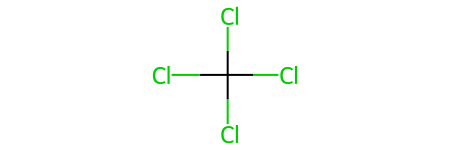

In [126]:
mol

In [127]:
def atom_set(molecule):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in mol.GetAtoms())
      return atom_symbols

In [128]:
from mendeleev import isotope, element
set_of_atoms = atom_set(mol)
# print(set_of_atoms)
isotopes = {}
for atom in set_of_atoms:
  # print(f"{atom=}")
  # print(f"{element(atom)=}")
  element_isotopes = element(atom).isotopes
  occuring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[atom] = occuring_isotopes
print(isotopes)

{'Cl': [[35, 0.758], [37, 0.242]], 'C': [[12, 0.9894], [13, 0.0106]]}


In [129]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.MolFromSmiles(sml)
    except:
      self.mol = Chem.MolFromSmiles(sml, sanitize=False)
    self.mass = Descriptors.ExactMolWt(self.mol)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

In [130]:
def set_isotopes(arr:np.ndarray, sml: str, current_index=()):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray,
        #   create molecule and set the isotopes of each of its atoms
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance
        return item

In [131]:
num_atoms = len(mol.GetAtoms())

# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

In [132]:
# Create the empty numpy ndarray with the specified shape
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

In [133]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [134]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)
len(mol_isotopes_flat)

32

In [135]:
mols_flat = [mol_isotope.mol for mol_isotope in mol_isotopes_flat]
abundance_flat = [mol_isotope.abundance for mol_isotope in mol_isotopes_flat]
mass_flat = [mol_isotope.mass for mol_isotope in mol_isotopes_flat]
legends = [f"{mass:.3f}: {abundance:.3f}" for mass, abundance in zip(mass_flat, abundance_flat)]
abundance_sum = sum(abundance_flat)
# Chem.Draw.MolsToGridImage(mols = mols_flat, legends = legends, molsPerRow=3)

It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the mass numbers is the same), so adding a tolerance risks lumping different molecules together. So it's best to use some discrete identifier. In this case, we use the SMILES, which contains isotope labels.

In [136]:
# Merge identical molecules
merged_molecular_isotpes = [mol_isotopes_flat[0]]
for molecular_isotope in mol_isotopes_flat[1:]:
  last_merged = merged_molecular_isotpes[-1]
  if Chem.MolToSmiles(molecular_isotope.mol) == Chem.MolToSmiles(last_merged.mol):
    last_merged.abundance += molecular_isotope.abundance
  else:
    merged_molecular_isotpes.append(molecular_isotope)

In [137]:
mols_merged_flat = [mol_isotope.mol for mol_isotope in merged_molecular_isotpes]
abundance_merged_flat = [mol_isotope.abundance for mol_isotope in merged_molecular_isotpes]
mass_merged_flat = [mol_isotope.mass for mol_isotope in merged_molecular_isotpes]
legends = [f"{mass:.9f}: {abundance:.3f}" for mass, abundance in zip(mass_merged_flat, abundance_merged_flat)]

In [138]:
for legend in legends:
  print(legend)

151.875410720: 0.327
152.878765560: 0.003
153.872460630: 0.417
154.875815470: 0.004
155.869510540: 0.200
156.872865380: 0.002
157.866560450: 0.043
158.869915290: 0.000
159.863610360: 0.003
160.866965200: 0.000


In [139]:
# Print masses and differences between adjacent molecules
for index, mass in enumerate(mass_merged_flat):
  if all([index > 0, index < len(mass_merged_flat) - 1]):
    print(f"{index:<4} {mass:<25} {mass_merged_flat[index-1]:<25} {mass - mass_merged_flat[index-1]}")

1    152.87876555999998        151.87541072              1.0033548399999859
2    153.87246062999998        152.87876555999998        0.9936950700000011
3    154.87581547              153.87246062999998        1.0033548400000143
4    155.86951054              154.87581547              0.9936950700000011
5    156.87286538              155.86951054              1.0033548400000143
6    157.86656045              156.87286538              0.9936950700000011
7    158.86991529              157.86656045              1.0033548399999859
8    159.86361036              158.86991529              0.9936950700000011


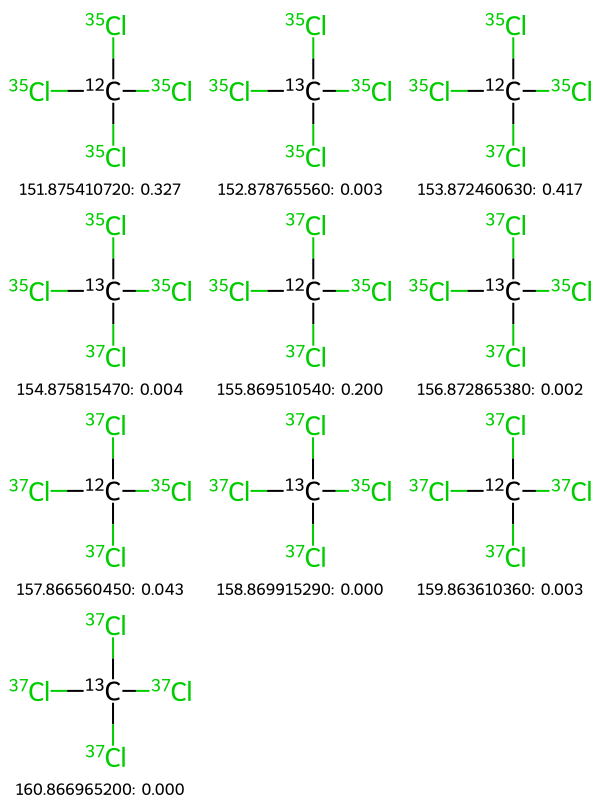

In [140]:
Chem.Draw.MolsToGridImage(mols = mols_merged_flat, legends = legends)

In [141]:
abundance_sum = sum(abundance_merged_flat)
print(abundance_sum)

1.0


In [142]:
df = pd.DataFrame({
    'Mass': mass_merged_flat,
    'Abundance': abundance_merged_flat
})

In [143]:
df = df.loc[df['Abundance'] >= 0.01]

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


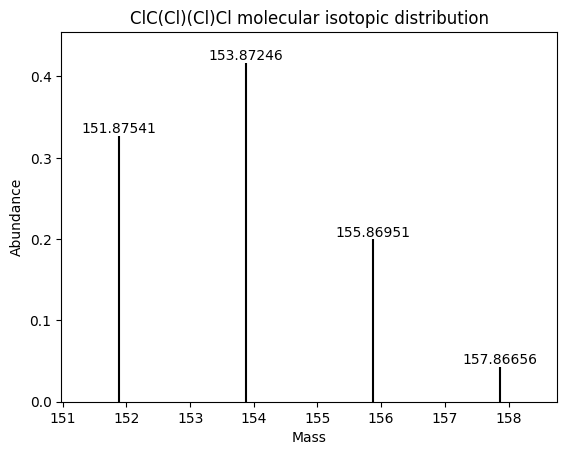

In [144]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='Mass', y='Abundance', data=df, marker='')

plt.xlabel('Mass')
plt.ylabel('Abundance')
plt.title(f'{sml} molecular isotopic distribution')

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df['Mass']) - min(df['Mass'])
xpad = xrange * 0.15
plt.xlim(min(df['Mass']) - xpad, max(df['Mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df['Abundance']) - min(df['Abundance'])
ypad = yrange * 0.1
plt.ylim(0, max(df['Abundance']) + ypad)

# Add vertical lines from each data point to the x-axis
for x, y in zip(df['Mass'], df['Abundance']):
    plt.vlines(x=x, ymin=0, ymax=y, colors='black')
    # Label the data points by mass
    plt.text(x=x, y=y, s=f'{x:.5f}', ha='center', va='bottom')

plt.show()

In [145]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [146]:
binomial_coefficient(3,2)

3

In [147]:
binomial_coefficient(3,1)

3

In [148]:
def composition(molecule):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule_with_Hs = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule_with_Hs.GetAtoms():
            comp[atom.GetSymbol()] += 1

        return comp

In [149]:
for element, count in composition(mol).items():
  print(element, count)

Cl 4
C 1


In [150]:
composition(mol)["Cl"]

4

In [151]:
isotopes

{'Cl': [[35, 0.758], [37, 0.242]], 'C': [[12, 0.9894], [13, 0.0106]]}

In [152]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

In [153]:
composition(mol)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': 4, 'C': 1})

In [183]:
mols:np.ndarray = np.array(None)

In [184]:
mols

array(None, dtype=object)

In [186]:
import numpy as np

# Create a zero-dimensional ndarray
zero_dim_array = np.array(42)

# Repeat the zero-dimensional array n times to create a 1-dimensional array
n = 5  # Change this to the desired number of repetitions
one_dim_array = np.repeat(zero_dim_array, n)

# Print the one-dimensional array
print(one_dim_array)

one_dim_array[0] = 7

print(one_dim_array)

[42 42 42 42 42]
[ 7 42 42 42 42]


In [178]:
import numpy as np

# Create a zero-dimensional ndarray
zero_dim_array = np.array(42)

# Print the array and its shape (should be an empty tuple)
print(zero_dim_array)
print(zero_dim_array.shape)

42
()


In [225]:
#Debugging only!
# isotopes = {'Cl': [[35, 0.5], [37, 0.5]]}

# Create a list to store the dimensions at each step
dimensions = []

mols:np.ndarray = np.array(Chem.Mol(mol))
print(f"{type(mols)=}")
print(f"Start: {mols=}")
for this_element, n_this_element in composition(mol).items():
  print(this_element, n_this_element)
  n_isotopes_this_element = len(isotopes[this_element])
  isotope_count_distribution = distribute_items(n_this_element, n_isotopes_this_element)
  n_distributions = len(isotope_count_distribution)
  # mols = np.repeat(mols, n_distributions)
  # mols = np.tile(mols, (n_distributions, 1))
  print(f"Before adding a dimension: {mols.shape=}")
  
  if mols.shape == ():
     mols = np.array([Chem.Mol(mol) for _ in range(n_distributions)], dtype=object)
     print(f"{type(mols)=}")
  else:
    # Create a list of copies of the current object
    mols_list = [copy.deepcopy(mols) for _ in range(n_distributions)]

    # Append the current object (list of copies) to the dimensions list
    dimensions.append(copy.deepcopy(mols_list))

    print(f"{type(mols)=}")
    
  print(f"{len(mols)=}")

  print(f"{mols=}")

  print(f"{n_this_element=}")

  sum_ab = 0
  masses = []
  for distribution_index, distribution in enumerate(isotope_count_distribution):
      print(distribution)
      a = 1
      b = binomial_coefficient(n_this_element, distribution[0])
      for isotope_index, isotope_count in enumerate(distribution):
        a_this_isotope = isotopes[this_element][isotope_index][1]
        a *= a_this_isotope**isotope_count
      ab = a*b
      sum_ab += ab
      print(f"{a=} {b=} {a*b=} {sum_ab=}")

      # To determine mass, set the correct number of atoms to each isotope
      distribution_countdown = distribution.copy()
      print(f"{distribution_countdown=}")
      for atom_index, atom in enumerate(this_mol.GetAtoms()):
        if atom.GetSymbol() == this_element:
          # Count down each isotope count, going on to the next when zero
          for isotope_index, isotope in enumerate(distribution):
            if distribution_countdown[isotope_index] > 0:
                # print(f"{isotopes[this_element][isotope_index][0]=}")
                atom.SetIsotope(isotopes[this_element][isotope_index][0])
                distribution_countdown[isotope_index] -= 1
                print(f"{distribution_countdown=}")
                break
      pass
print(f"{sum_ab=}")
mols = np.array(dimensions[-1])
print(f"{mols=}")
print(f"{type(mols)=}")


type(mols)=<class 'numpy.ndarray'>
Start: mols=array(<rdkit.Chem.rdchem.Mol object at 0x1390a5940>, dtype=object)
Cl 4
Before adding a dimension: mols.shape=()
type(mols)=<class 'numpy.ndarray'>
len(mols)=5
mols=array([<rdkit.Chem.rdchem.Mol object at 0x1390a54e0>,
       <rdkit.Chem.rdchem.Mol object at 0x1384fcb30>], dtype=object)
n_this_element=4
[0, 4]
a=0.0034297420959999996 b=1 a*b=0.0034297420959999996 sum_ab=0.0034297420959999996
distribution_countdown=[0, 4]
distribution_countdown=[0, 3]
distribution_countdown=[0, 2]
distribution_countdown=[0, 1]
distribution_countdown=[0, 0]
[1, 3]
a=0.010742745904 b=4 a*b=0.042970983616 sum_ab=0.046400725712
distribution_countdown=[1, 3]
distribution_countdown=[0, 3]
distribution_countdown=[0, 2]
distribution_countdown=[0, 1]
distribution_countdown=[0, 0]
[2, 2]
a=0.033648766095999996 b=6 a*b=0.20189259657599998 sum_ab=0.24829332228799997
distribution_countdown=[2, 2]
distribution_countdown=[1, 2]
distribution_countdown=[0, 2]
distribution_c

In [210]:
len(mols)

2

In [216]:
import numpy as np
import copy

# Create an initial 0-dimensional object
object0d = {"name": "Alice", "age": 30}

# Define the number of dimensions to create (0 to 3)
num_dimensions = 3

# Define the number of copies to make at each dimension
m = 4

# Initialize the current object to the 0-dimensional object
current_object = object0d

# Create a list to store the dimensions at each step
dimensions = []

# Loop through the desired number of dimensions
for _ in range(num_dimensions):
    # Create a list of m copies of the current object
    current_object = [copy.deepcopy(current_object) for _ in range(m)]
    
    # Append the current object (list of m copies) to the dimensions list
    dimensions.append(copy.deepcopy(current_object))

# Convert the dimensions list to a NumPy array
final_array = np.array(dimensions[-1])

# Print the final multi-dimensional array
print(final_array)


[[[{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]
  [{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]
  [{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]
  [{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]]

 [[{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]
  [{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]
  [{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]
  [{'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}
   {'name': 'Alice', 'age': 30} {'name': 'Alice', 'age': 30}]]

 [[{'name': 

In [192]:
mols

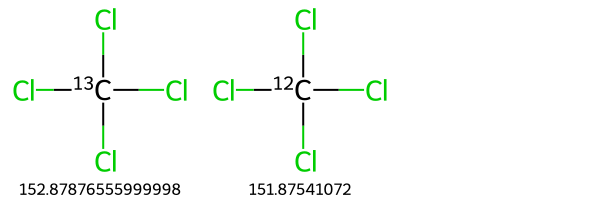

In [191]:
# Chem.Draw.MolsToGridImage(mols, legends=[str(mass) for mass in masses])
Chem.Draw.MolsToGridImage(mols, legends=[str(mass) for mass in masses])

Divider

In [155]:
# #Debugging only!
# # isotopes = {'Cl': [[35, 0.5], [37, 0.5]]}

# n_atoms = 2

# n_enumerated = 0
# # n_test_atoms = 4
# # for isotope_count in range(n_test_atoms + 1):
# for isotope_count in range(n_atoms + 1):
#     n_enumerated += binomial_coefficient(n_atoms, isotope_count)

# print(f"{n_enumerated=}")

# #Debugging only!
# # n_atoms = 3

# sum_ab = 0
# for isotope_count in range(n_atoms + 1):
#   # for isotope in isotopes["Cl"]:
#     n_this_isotope = isotope_count
#     mass_this_isotope = isotopes["Cl"][0][0]
#     n_other_isotope = n_atoms - isotope_count
#     mass_other_isotope = isotopes["Cl"][1][0]
#     a_this_isotope = isotopes["Cl"][0][1]
#     a_other_isotope = isotopes["Cl"][1][1]
#     b = binomial_coefficient(n_atoms, n_this_isotope)
#     a_from_this_isotope = (a_this_isotope**n_this_isotope)
#     a_from_other_isotope = (a_other_isotope**n_other_isotope)
#     # print(f"this isotope : {n_this_isotope} {mass_this_isotope} {a_this_isotope} {a_this_isotope**n_this_isotope} {binomial_coefficient(n_atoms, n_this_isotope)} {a_from_this_isotope}")
#     # print(f"other isotope: {n_other_isotope} {mass_other_isotope} {a_other_isotope} {a_other_isotope**n_other_isotope} {binomial_coefficient(n_atoms, n_other_isotope)} {a_from_other_isotope}")
#     headers = "n          Mass     A      Result       Frac A_from"

#     # Define the data for the first isotope
#     data1 = f"{n_this_isotope:<12} {mass_this_isotope:<6} {a_this_isotope:<6} {a_this_isotope**n_this_isotope:<12} {a_from_this_isotope}"

#     # Define the data for the other isotope
#     data2 = f"{n_other_isotope:<12} {mass_other_isotope:<6} {a_other_isotope:<6} {a_other_isotope**n_other_isotope:<12} {a_from_other_isotope}"

#     print(headers)
#     print(data1)
#     print(data2)

#     a = a_from_this_isotope * a_from_other_isotope
#     print(f"{a=} {b=} {a*b=}")
#     sum_ab += a*b
# print(f"{sum_ab=}")
#     # print(isotope)

In [156]:
for element, count in composition(mol).items():
    abundance = isotopic_abundances[element]
    contribution *= pow(abundance, count)
    contribution *= binomial_coefficient(molecular_formula[element_symbol], count)
return contribution


NameError: name 'isotopic_abundances' is not defined